In [27]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
df = pd.read_csv('E:\ksp\Kerbal Space Program\cods\Programming\data.csv')

# Extract data from columns
time_values = df['Time']
velocity_values = df['Velocity']
acceleration_values = df['Acceleration']


In [70]:
# Константы
# g # ускорение свободного падения, м/с^2
# v0 # начальная скорость, м/с
# C # коэффициент сопротивления воздуха
# p0 # плотность воздуха на уровне моря, кг/м^3

# # Другие параметры
# E # параметр, связанный с тягой
# T # характерное время в экспоненте
# m0 # начальная масса
# a # коэффициент в уравнении массы

CONSTANTS = {'g': 9.81,
             'v0': 0.37,
             'p0': 1.225,
             'E': (7770e3 * 5 - 6770e3 * 5) / 110,
             'T': 110,
             'm0': 2_900_000,
             'a': 12200,
             'C': 0.45 * np.square(13) / 2_900_000 * 1000}


def ballist_coefficient(C: float = CONSTANTS['C'], p0: float = CONSTANTS['p0']) -> float:
    return np.pi * p0 * C / 8000


def cx(ma: float) -> float:
    if ma < .073:
        return 0.157
    elif ma < 0.82:
        return 0.033 * ma + 0.133
    elif ma < 0.91:
        return 0.161 + 3.9 * np.square(ma - 0.823)
    elif ma < 1.00:
        return 1.5 * ma - 1.176
    elif ma < 1.18:
        return 0.384 - 1.6 * np.square(ma - 1.176)
    elif ma < 1.62:
        return 0.384 * np.sin(1.85 / ma)
    elif ma < 3.06:
        return 0.29 / ma + 0.172
    elif ma <= 3.53:
        return 0.301 - 0.011 * ma
    return 0.26


def air_density(h: float) -> float:
    if h < 11000:
        return np.power(1 - h / 44300, 4.256)
    return 0.29784 * np.power(np.exp(1), (11000 - h) / 6342)


def ma_func(vel: float, az: float) -> float:
    return vel / az


def veloc_z(h: float) -> float:
    if h < 11000:
        return 20.046796 * np.sqrt(288.15 - 0.0065 * h)
    return 295.69


def windage(v: float, h: float) -> float:
    a = veloc_z(h)
    ma = ma_func(v, a)
    return ballist_coefficient() * air_density(h) * np.square(v) * cx(ma)


def mass_consumption(t: float,
                     m0: float = CONSTANTS['m0'],
                     a: float = CONSTANTS['a']) -> float:
    return m0 - a * t


def thrust(t: float,
           E: float = CONSTANTS['E']) -> float:
    return 6770e3 * 5 + E * t


def alpha(t: float,
          T: float = CONSTANTS['T']) -> float:
    return np.radians(90) * np.exp(-t / T)


# Система дифференциальных уравнений
def model(t, y, CONSTANTS: map = CONSTANTS):
    vy, vx, h = y
    v = np.sqrt(np.square(vy) + np.square(vx))
    dydt = [
        (thrust(t) * np.sin(alpha(t)) - mass_consumption(t) * CONSTANTS['g'] - windage(v, h) * np.sin(
            alpha(t))) / mass_consumption(t),
        ((thrust(t) * np.cos(alpha(t)) - windage(v, h) * np.cos(alpha(t))) / mass_consumption(t)) + (
                CONSTANTS['v0'] / (t + 1e-6)),
        vy
    ]

    return dydt

# # Извлекаем решения
# vy, vx, h = solution.T

In [71]:
# Начальные условия
y0 = [0, 0, 0]

# Время
# t = np.linspace(1, 170, 1000000)

# Решение системы уравнений
solution = scipy.integrate.solve_ivp(model, [0, 110], y0)

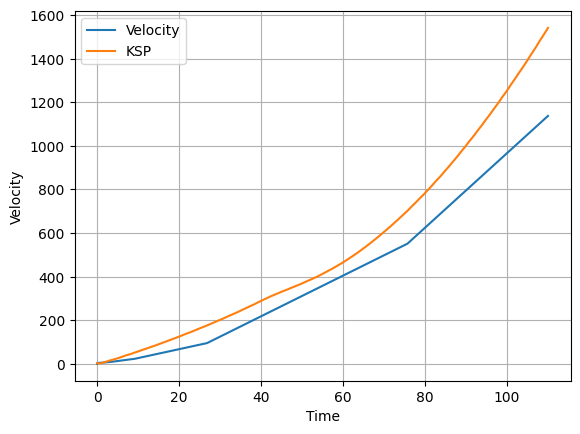

In [76]:
# Вывести результат
t = np.linspace(0, 110, 110)
velocity_values_interp = np.interp(t, time_values, velocity_values)

v = []
for time in range(len(solution.y[0])):
    v.append(np.sqrt(np.square(solution.y[0][time]) + np.square(solution.y[1][time])))
plt.plot(solution.t, v, label='Velocity')
plt.plot(t, velocity_values_interp, label='KSP')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.show()

In [54]:
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.651e-06 ...  7.572e+01  1.100e+02]
        y: [[ 0.000e+00  1.239e-05 ...  2.345e+02  3.604e+02]
            [ 0.000e+00  7.742e-01 ...  4.992e+02  1.079e+03]
            [ 0.000e+00  4.119e-11 ...  8.140e+03  1.831e+04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 176
     njev: 0
      nlu: 0